# Impressions on the lc_classif python package

## Content

1. Import of Necessary Python Modules
2. Conduct resampling and subsetting of data and mask
3. Import of Data and First Impressions on Classes
4. Analyze and Impute Missing Values
5. Analyze Class Separability
6. Split into Test and Training Dataset
7. Basic Random Forest Model
8. Tuning Base Model
9. Base Model with Feature Selection

# 1. Import of Necessary Python Modules

In [1]:
from RanForCorine import geodata_handling as datahandler
from RanForCorine import data_cleaning as clean
from RanForCorine import descriptive_stats as descr
from RanForCorine import separability as sep
from RanForCorine import test_training_separation as tts
from RanForCorine import randomforest_classifier as rf
from RanForCorine import accuracy as acc
from RanForCorine import tuning as tuning
from RanForCorine import feature_importance as feat
from RanForCorine import visualization as vis
import numpy as np
import osr

# 2. Resampling and subsetting of the data

Before starting the selection of the classes and training the random forest model, a preparation of the data might be necessary. The data and land cover mask should have the same extend and resolution. The Sentinel-1 data will then be split into the backscatter values of the classes in a DataFrame.

In [ ]:
# set the nexessary file paths
fp_stack=r"Path\to\Sentinel1\data"
fp_hdr=r"Path\to\Sentinel1\data.hdr"
fp_mask=r"Path\to\CorineLandCover\mask.tif"
fp_s1_res=r'Path\to\save\resampled\Sentinel1'
fp_mask_sub=r'Path\to\save\subsetted\CLC\mask.tif'
fp_csv=r'Path\to\save\splitted\data.csv'
fp_out=r'Path\to\save\result.tif'

In [ ]:
# adjust pixel size and extend of S-1 data and mask
datahandler.adjust(fp_stack,fp_mask, epsg=32633, write=True, outfp1=fp_s1_res,\
                    outfp2=fp_mask_sub,hdrfp=fp_hdr,subset=False)

In [2]:
# split the Sentinel-1 data into the Corine land Cover classes and return the DataFrame
data_raw=datahandler.split_classes(fp_s1_res,fp_mask_sub)
data_raw.head()

The data consists of 423 rows, 455 columns


,Label_nr,Band_0,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_9
0,211,-1.712054,-10.977893,-7.573957,-12.032084,-10.777917,-15.891901,-11.865086,-10.157995,-8.595594,-9.261912
1,211,-9.028224,-8.730456,-6.578631,-7.148839,-7.280691,-8.841081,-7.206702,-7.563174,-5.867866,-9.521194
2,211,-11.620181,-9.992731,-11.809107,-15.291870,-11.016249,-10.383938,-12.345720,-11.327520,-9.365889,-11.485276
3,211,-10.486684,-11.689506,-7.771171,-14.770417,-14.709775,-10.133624,-13.046339,-10.255915,-10.655959,-9.791854
4,211,-12.302423,-10.598193,-11.326790,-18.658617,-10.834291,-15.426160,-15.883271,-10.016912,-10.947848,-11.512190


# 3. First Impressions on Classes

In this section data is imported and first impressions on the dataset are shown. For example there is a barplot showing how many pixels/values there are per class. As it will be seen later on, the amount of pixels has a substantial impact on the class separability.

Index(['Label_nr', 'Band_0', 'Band_1', 'Band_2', 'Band_3', 'Band_4', 'Band_5',
       'Band_6', 'Band_7', 'Band_8', 'Band_9'],
      dtype='object')


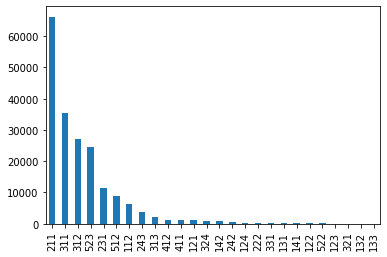

In [3]:
# IMPORT DATA ################################
# data_raw = datahandler.importCSV(r"Path\to\splitted\data.csv").drop(data_raw.columns[0], axis=1) #remove index column
print(data_raw.columns)

# FIRST IMPRESSIONS ##########################
class_count = descr.countPxlsPerClass(data_raw, "Label_nr")
class_count.plot.bar()

Furthermore it is possible to plot histograms for selected classes. As shown below for the data of Vattenrike class distributions are very differnt throughout the dataset.

In [ ]:
# plot histogram
descr.plotHist(data_raw, 211, "Label_nr")

In [ ]:
# plot histogram
descr.plotHist(data_raw, 522, "Label_nr")

# 4. Analyze and Impute Missing Values

As the Random Forest model used in this package is based on scikit-learn it cannot operate on null values in the data. Before computing the model it is neccessary to get rid of any missing values. The package provides the opportunity to count missing data fields and impute them with the mean of the column where it is located.

In [4]:
# MISSING VALUES #############################
print("--- ANALYZING MISSING VALUES ---")
missing_count = clean.countMissingValuesTotal(data_raw, null_value=-99.0)
print(str(missing_count) + " values are missing.")
# Impute missing values with mean in column
data_imp = clean.imputeMean(data_raw, clean=True, null_value=-99.0)
print("Done imputing missing values.")

--- ANALYZING MISSING VALUES ---
790 values are missing.
Done imputing missing values.


# 5. Analyze Class Separability

As there are so many classes in the dataset, it is recommended to analyze their separability. For this purpose three different distance measures can be calculated. In this example the euclidean distance is shown in a heatmap clearly visualizing the best separable classes.

--- ANALYZING CLASS SEPARABILITY ---


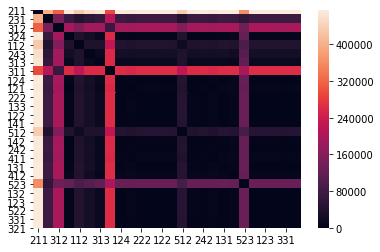

In [5]:
# CLASS SEPARABILITY ##########################
print("--- ANALYZING CLASS SEPARABILITY ---")
class_sep = sep.calcSep(data_imp, "Label_nr")
sep.printHeatmap(class_sep, "Euclidean")

To use only those classes for the model it is neccessary to compress all remaining classes to one class. The plot shows that now there are approximately 15,000 pixels of the class 0. 

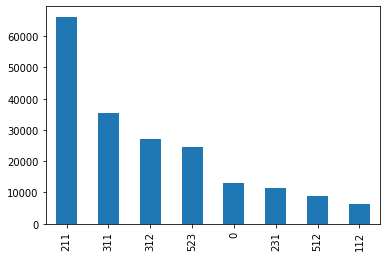

In [6]:
# we decided to use following classes
sep_list = [112,211,231,311,312,523,512]

# add column to dataset setting all unwanted class values to 0
data_comp = clean.compressClasses(data_imp, sep_list, "Label_nr", "Label_new")
# count number of pixels per class
class_count_comp = descr.countPxlsPerClass(data_comp, "Label_new")
class_count_comp.plot.bar()



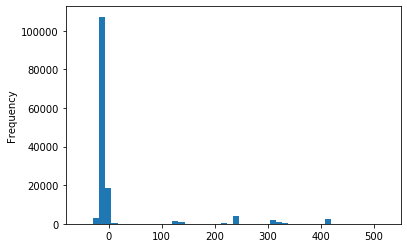

In [7]:
# plot histogram
descr.plotHist(data_comp, 0, "Label_new")

A new separability analysis compares the remaining classes.

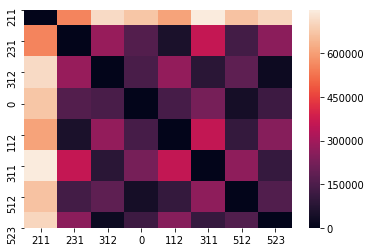

In [8]:
# show new separability
class_sep2 = sep.calcSep(data_comp, "Label_new")
sep.printHeatmap(class_sep2, "Euclidean")

# 6. Split into Test and Training Dataset

In this step the images are split into test and training dataset. Whereas the training dataset needs to be larger and is used to train the model, the test dataset will be used to predict class values. Class labels are split into test and training datasets as well. 
As this package should be used with image classification, the test dataset is always the upper proportion of the image. In this example we used a proportion of 0.3 for the testsize. So the upper 30 % of the images are used for testing or rather prediction. The lower 70 % are used to train the model.

In [9]:
# TEST TRAINING #################################
print("--- Test Training Split ---")
x_train, x_test, y_train, y_test = tts.imageSplit(data_comp, labelcol="Label_new", imagedim=[455,423], testsize=0.3)

--- Test Training Split ---


# 7. Basic Random Forest Model

Now it is time for the basic Random Forest (RF) model. To keep computing time possibly low we decided to go with low max_depth and n_estimator values which definitely results into a model that is not a powerful as it could be.
The model is fitted to the training data and after that the prediction is carried out.

In [10]:
# RANDOM FOREST BASE MODEL ######################
print("--- CALCULATING BASE MODEL ---")
base_model = rf.RandomForestClassifier(max_depth=2, random_state=1, n_estimators=50)
rf.fitModel(base_model, x_train, y_train)
print("--- DONE FITTING MODEL ---")
base_pred = rf.predictModel(base_model, x_test)
print("--- DONE PREDICTING ---")

--- CALCULATING BASE MODEL ---
--- DONE FITTING MODEL ---
--- DONE PREDICTING ---


The accuracy score shows that this model only has an accuracy of about 55 %. The confusion matrix is printed to show the predicted versus the actual values.

In [11]:
# ACCURACY
base_acc = acc.getAccuracy(base_pred, y_test)
print("Base model has accuracy of: " + str(base_acc)) 
base_conf = acc.getConfMatrix(base_pred, y_test)
classes = [0, 112, 211, 231, 311, 312, 512, 523]
acc.printConfMatrix(base_conf, classes)

Base model has accuracy of: 0.5586051743532059
           0 (pred)  112 (pred)  211 (pred)  231 (pred)  311 (pred)  \
0 (act)           0           0        1413           0        2619   
112 (act)         0           0        1879           0           0   
211 (act)         0           0       21001           0           0   
231 (act)         0           0        1035           0        1877   
311 (act)         0           0         718           0       11278   
312 (act)         0           0         581           0        9105   
512 (act)         0           0         174           0         290   
523 (act)         0           0           0           0           0   

           312 (pred)  512 (pred)  523 (pred)  
0 (act)             0           0         137  
112 (act)           0           0           0  
211 (act)           0           0          12  
231 (act)           0           0          97  
311 (act)           0           0          49  
312 (act)           0    

The predicted image can be printed clearly showing that only a few classes could be classified with this model.

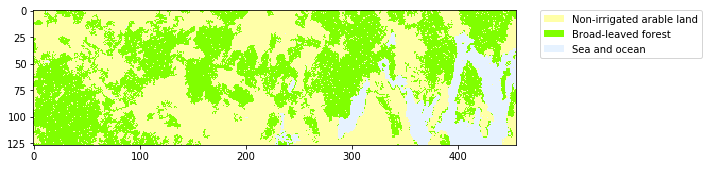

In [12]:
vis.plotResult(base_pred, [127, 455])

# 8. Tuning Base Model

As it is impossible to find the right combination of parameters for a complex RF model it is recommended to use hyperparameter tuning. The best setting is tried to be found using a three-fold cross-validation over a grid of possible parameter values. This clearly shows an improvement in accuracy.

In [13]:
# BASE MODEL TUNING
print("--- TUNING BASE MODEL ---")
base_params = tuning.getParamsOfModel(base_model)
print(base_params)
max_depth_base = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth_base.append(None)
base_grid = {'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 200, num = 5)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': max_depth_base}
best_base_model = tuning.tuneModel(base_grid, x_train, y_train, n_jobs=1)
best_base_pred = rf.predictModel(best_base_model, x_test)
best_base_acc = acc.getAccuracy(best_base_pred, y_test)
print("Tuned base model has accuracy of: " + str(best_base_acc)) #0.9001

--- TUNING BASE MODEL ---
{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] n_estimators=50, max_features=auto, max_depth=10 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . n_estimators=50, max_features=auto, max_depth=10, total=  20.8s
[CV] n_estimators=50, max_features=auto, max_depth=10 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.8s remaining:    0.0s


[CV] . n_estimators=50, max_features=auto, max_depth=10, total=  19.2s
[CV] n_estimators=50, max_features=auto, max_depth=10 ................
[CV] . n_estimators=50, max_features=auto, max_depth=10, total=  19.4s
[CV] n_estimators=50, max_features=sqrt, max_depth=10 ................
[CV] . n_estimators=50, max_features=sqrt, max_depth=10, total=  20.4s
[CV] n_estimators=50, max_features=sqrt, max_depth=10 ................
[CV] . n_estimators=50, max_features=sqrt, max_depth=10, total=  18.7s
[CV] n_estimators=50, max_features=sqrt, max_depth=10 ................
[CV] . n_estimators=50, max_features=sqrt, max_depth=10, total=  18.9s
[CV] n_estimators=87, max_features=sqrt, max_depth=85 ................
[CV] . n_estimators=87, max_features=sqrt, max_depth=85, total=  37.6s
[CV] n_estimators=87, max_features=sqrt, max_depth=85 ................
[CV] . n_estimators=87, max_features=sqrt, max_depth=85, total=  38.0s
[CV] n_estimators=87, max_features=sqrt, max_depth=85 ................
[CV] .

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.8min finished


Tuned base model has accuracy of: 0.9938565371636238


In [14]:
best_base_acc = acc.getAccuracy(best_base_pred, y_test)
print("Tuned base model has accuracy of: " + str(best_base_acc)) 
best_base_conf = acc.getConfMatrix(best_base_pred, y_test)
classes = [0, 112, 211, 231, 311, 312, 512] #list here the class numbers in ascending order
acc.printConfMatrix(best_base_conf, classes)

Tuned base model has accuracy of: 0.9938565371636238
           0 (pred)  112 (pred)  211 (pred)  231 (pred)  311 (pred)  \
0 (act)        4104           0           0          65           0   
112 (act)         0        1879           0           0           0   
211 (act)         0           0       21013           0           0   
231 (act)         0           0           0        3009           0   
311 (act)         4           0           0          14       12027   
312 (act)         1           0           0           1           3   
512 (act)       266           0           0           0           0   

           312 (pred)  512 (pred)  
0 (act)             0           0  
112 (act)           0           0  
211 (act)           0           0  
231 (act)           0           0  
311 (act)           0           0  
312 (act)        9697           0  
512 (act)           1        5701  


As it can be seen in the plotted result all classes could be predicted.

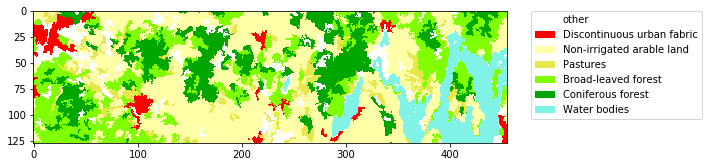

In [16]:
vis.plotResult(best_base_pred, [127, 455])

# 9. Base Model with Feature Selection

In addition to tuning it is possible to use feature selection. As we got more than 200 features or rather images in this dataset the plot shows the 10 most important ones.

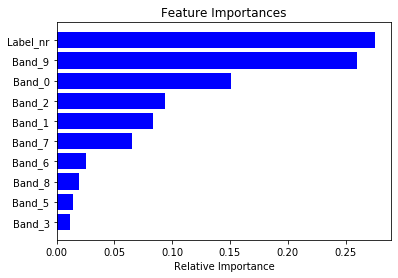

In [17]:
feat.importancePlot(base_model, x_train.columns, 10)

Based on those important features it is possible to carry out a new classification by training a new model. This slightly improves the base model.

In [18]:
# select important features
x_important_test, x_important_train = feat.selectImportantFeatures(base_model, x_train, y_train, x_test)
sel_model = rf.RandomForestClassifier(max_depth=2, random_state=1, n_estimators=50)
rf.fitModel(sel_model, x_important_train, y_train)
sel_pred = rf.predictModel(sel_model, x_important_test)
sel_acc = acc.getAccuracy(sel_pred, y_test)
print("Model with selected features as accuracy of: " + str(sel_acc)) #0.67

4 features selected
Index(['Label_nr', 'Band_0', 'Band_2', 'Band_9'], dtype='object')
Model with selected features as accuracy of: 0.5718439041273687


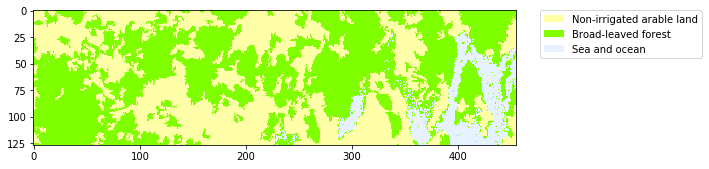

In [19]:
vis.plotResult(sel_pred, [127, 455])

In [26]:
# save the result to disk as GeoTIFF"
result=sel_pred.reshape((127, 455))
ds=datahandler.read_file_gdal(fp_s1_res)
gt=ds.GetGeoTransform()
srs=osr.SpatialReference()
srs.ImportFromWkt(ds.GetProjection())
datahandler.create_gtiff(sel_pred,gt,srs,fp_out)

file import done.
